# <center>MoA - EDA and simple PyTorch Baseline -</center> 

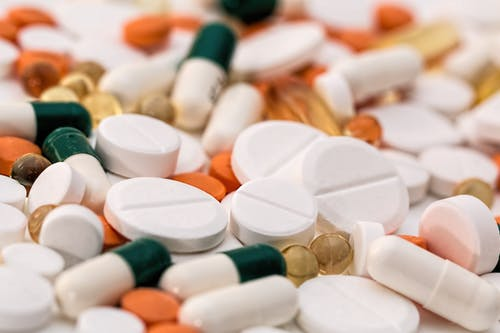

1. [Introduction](#section1)
2. [EDA](#section2) 
3. [Baseline](#section3)

<div id='section1'/>

## 1. Introduction

### 1.1 What's MoA (Mechanisms of Action) and how? 
According to [official description of this competition](https://www.kaggle.com/c/lish-moa/overview/description), MoA is a numerical measurement for biological activity of chemical molecules (i.e. drug) which targets to modulate disease they are focusing. For how part, they give the test drug to the test human cell and record cellular response, which can be derived by algorithm that retrieves similarities from know patterns in geometric databases.

### 1.2 Goal of this competition
We are going to construct an algorithm that automaticaly labels each case in test set based on train set. Note that this competition does not specify the target varible to one, but also can be classified into multiple cases. 

### 1.3 Evaluation metric (score)
Score is derived from modified version of log loss: 

$$score = -\frac{1}{M}\sum\limits_{m=1}{M}\frac{1}{N}\sum\limits_{i=1}{N}[y_{i, m}log(\hat{y}_{i,m})+(1-y_{i,m})(1-\hat{y}_{i,m})]$$

Where: 
* $N$ is the number of sig_id observations in the test data (i=1,…,N)
* $M$ is the number of scored MoA targets (m=1,…,M)
* $\hat{y}_{i,m}$ is the predicted probability of a positive MoA response for a sig_id
* $y_{i,m}$ is the ground truth, 1 for a positive response, 0 otherwise
* $log()$ is the natural (base e) logarithm

<div id='section'/>

## 2. Quick data look-in

### Explanation of csv data
See [official explanation](https://www.kaggle.com/c/lish-moa/data) since it's most detailed one.

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
# Global meta data 
DATA_DIR = '../input/lish-moa/'
WORK_DIR = '../working/'

Check from submission file since it's a final form of prediction.

In [ ]:
sample_sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
# shape of submission 
print(sample_sub.shape)
sample_sub.head()

Check train data

In [ ]:
train_features = pd.read_csv(DATA_DIR + 'train_features.csv')
# shape of train_features
print(train_features.shape)
# check head of data
train_features.head()

In [ ]:
train_features.isnull().sum().sum()

In [ ]:
# check duplicates
train_features['sig_id'].nunique()

Hooray! We don't have any missing/duplicated values for now! What about the unique values in categorical values??

In [ ]:
# categorical unique values 
print('Unique values in cp_type: ', train_features['cp_type'].unique())
print('Unique values in cp_dose: ', train_features['cp_dose'].unique())
# we can treat cp_time as categorical valriable from description
print('Unique values in cp_time: ', train_features['cp_time'].unique())

We can label encode these (OHE). Let's check the distribution of categorical values.

In [ ]:
cat_cols = ['cp_type', 'cp_dose', 'cp_time']

# Count plot for all categorical variables
plt.figure(figsize=(5, 20))
for i, col in enumerate(cat_cols):
    plt.subplot(3, 1, i+1)
    plt.title(col)
    sns.countplot(train_features[col], palette='Blues')

Seems cp_type has skewed distribution. Otherwise, we cannot observe significant features. **Maybe we can split data w.r.t cp_type, since multiple target variables exists.** 

I will laave detailed exploration for numerical data, since it is too much. Just touch with basic infos.

In [ ]:
# how many c and g columns?
g_cols = [col for col in train_features.columns if 'g-' in col]
c_cols = [col for col in train_features.columns if 'c-' in col]

# print first 10 column names and total length of c- and g- columns 
print(f'First 10 columns for g-: {g_cols[:10]}')
print(f'Length of columns with g-: {len(g_cols)}')
print(f'First 10 columns for c-: {c_cols[:10]}')
print(f'Length of columns with c-: {len(c_cols)}')

We now know that columns with "g-" is from g-0 to g-771, and c-0 to c-99 for "c-". From now on, we will look at train_targets_scored, which contains target variables. 

In [ ]:
train_target = pd.read_csv(DATA_DIR + 'train_targets_scored.csv')
print(train_target.shape)
train_target.head()

train_target and sample submission has identical column numbers. Check are columns same. 

In [ ]:
list(sample_sub.columns) == list(train_target.columns)

Qualified that train_target and sample_sub columns are identical. This fact gives an intuition that **we just need to create model which takes variables (and potential features to be created) in train_features, and train based on train_target values**. As instruction says, target is binary representation, so semi-OHE. Now, we will take a look at test_features.csv. We will repeat the look over process that we used in train_features. 

In [ ]:
test_features = pd.read_csv(DATA_DIR + 'test_features.csv')
print(test_features.shape)
test_features.head()

In [ ]:
test_features.isnull().sum().sum()

In [ ]:
test_features['sig_id'].nunique()

In [ ]:
# Count plot for all categorical variables
plt.figure(figsize=(5, 20))
for i, col in enumerate(cat_cols):
    plt.subplot(3, 1, i+1)
    plt.title(col)
    sns.countplot(test_features[col], palette='Blues')

Thanksfully, distribution of train and test dataset are similar (almost identical). Thus, we will take in the distibution of train data as a consideration. 

<div id='section1'/>

## 3. Baseline

This baseline is actually a 'baseline', so I did not implement fancy techniques or sorts. I will write down what to do with this baseline in the end of this notebook.

In [ ]:
from collections import OrderedDict
from pathlib import Path 
import os
import sys

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

sys.path.append('../input/iter-strat/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [ ]:
# Config data
EPOCHS = 30
DROPOUT = 0.3
STEP_SIZE = 10
FOLDS = 5
HIDDEN_SIZE = 1024
BATCH_SIZE = 1024
LR = 3e-3
SPLIT_COL = 'cp_type'

In [ ]:
# Data preprocessing
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sub = pd.read_csv('../input/lish-moa/sample_submission.csv')
targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

# Label encode categorical variables 
cp_type = {'trt_cp': 0, 'ctl_vehicle': 1}
cp_time = {24: 0, 48: 1, 72: 2}
cp_dose = {'D1': 0, 'D2': 1}

for data in [train_features, test_features]:
    data['cp_type'] = data['cp_type'].map(cp_type)
    data['cp_time'] = data['cp_time'].map(cp_time)
    data['cp_dose'] = data['cp_dose'].map(cp_dose)
    
# get columns for features and targets
feature_cols = list(train_features.drop('sig_id', axis=1).columns)
target_cols = list(targets.drop('sig_id', axis=1).columns)

# configure input and output size 
INPUT_SIZE = len(feature_cols)
OUTPUT_SIZE = len(target_cols)

# set fold number for data
train_features.loc[:, 'fold'] = -1

skf = MultilabelStratifiedKFold(n_splits=FOLDS)
for fold, (train_ind, val_ind) in enumerate(skf.split(train_features, targets.drop('sig_id', axis=1))):
    train_features.loc[val_ind, 'fold'] = fold

# merge train features and targets
train_data = train_features.merge(targets, on='sig_id').reset_index()

In [ ]:
# define dataset for both train and test
class TrainData(Dataset):
    def __init__(self, table_data, features, targets):
        super().__init__()
        self.features = table_data[features].values
        self.targets = table_data[targets].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, ind):
        X = torch.Tensor(self.features[ind])
        y = torch.Tensor(self.targets[ind])
        return X, y

class TestData(Dataset):
    def __init__(self, table_data):
        super().__init__()
        self.test = table_data.drop('sig_id', axis=1).values

    def __len__(self):
        return len(self.test)

    def __getitem__(self, ind):
        X = torch.Tensor(self.test[ind])
        return X


In [ ]:
# Define model (NN)
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDDEN_SIZE), 
            nn.BatchNorm1d(HIDDEN_SIZE),
            nn.Dropout(DROPOUT), 
            nn.ReLU(), 
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE), 
            nn.BatchNorm1d(HIDDEN_SIZE), 
            nn.Dropout(DROPOUT), 
            nn.ReLU(), 
            nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
        )

    def forward(self, inputs):
        inputs = self.net(inputs)
        return inputs

In [ ]:
# set everything needed for training and validation
class Train:
    def __init__(self, model, optim, device):
        self.model = model 
        self.optim = optim 
        self.device = device 
    
    @staticmethod
    def loss_fn(output, target):
        return nn.BCEWithLogitsLoss()(output, target)
    
    # train method 
    def train(self, train_loader):
        # seet model to training mode
        self.model.train()
        single_loss = 0
        
        for x, y in train_loader:
            # initialize optimizer 
            self.optim.zero_grad()
            # move x and y to device 
            x, y = x.to(self.device), y.to(self.device)
            # output from model 
            out = self.model(x)
            # compute loss based on output and target values
            loss = self.loss_fn(out, y)
            # back propagation 
            loss.backward()
            # update optimizer 
            self.optim.step()
            # add loss to calculate loss 
            single_loss += loss.item()
            
        # return average loss 
        return single_loss / len(train_loader)

    def validation(self, val_loader):
        # set model to evaluation mode 
        self.model.eval()
        single_loss = 0
        
        for x, y in val_loader:
            x, y = x.to(self.device), y.to(self.device)
            # without gradients 
            with torch.no_grad():
                out = self.model(x)
                loss = self.loss_fn(out, y)
                single_loss += loss.item()
                
        return single_loss / len(val_loader)

In [ ]:
def train_step(train_data, test_data, fold, features, targets, device):
    ### Training and validation for one fold ###
    # get train and val data 
    train = train_data[train_data['fold']!=fold].reset_index(drop=True)
    val = train_data[train_data['fold']==fold].reset_index(drop=True)
    
    # convert into tensor 
    train_set = TrainData(train, features, targets)
    val_set = TrainData(val, features, targets)
    
    # define data loader for both train and test data 
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    # define model, optimizer and scheduler
    model = Model()
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    # due to the epoch number, I did not define scheduler but if you want, try out
    
    # define Train class 
    trainer = Train(model, optim, device)
    
    # configs 
    best_weight = ''
    best_loss = np.inf
    train_losses = []
    val_losses = []
    
    # epoch loop
    for epoch in range(EPOCHS):
        # compute train and val loss 
        train_loss = trainer.train(train_loader)
        val_loss = trainer.validation(val_loader)

        # append all values and use for computing mean 
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # update (or keep track on) model which results with better val loss
        if val_loss < best_loss:
            print(f'Updating best model weights in epoch {epoch+1}: {val_loss}')
            # save best model weight (so far)
            torch.save(model.state_dict(), f'{fold}_{epoch}.pth')
            # track file for best weight (so far)
            best_weight = f'{fold}_{epoch}.pth'
            # update best loss 
            best_loss = val_loss
    
    print(f'FOLD #{fold+1}: Average train loss: {np.mean(np.array(train_losses))}, Average val loss: {np.mean(np.array(val_losses))}')
    
    # get test dataset and loader 
    test_set = TestData(test_data)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    
    # define model for testing (prediction)
    model = Model()
    model.load_state_dict(torch.load(best_weight))
    model.to(device)
    
    # compute prediction
    preds = test_step(model, test_loader, device)

    return preds

In [ ]:
def test_step(model, test_loader, device):
    # evaluation mode 
    model.eval()
    preds = []
    
    # prediction loop
    for x in test_loader:
        x = x.to(device)
        
        with torch.no_grad():
            pred = model(x)
        
        # append predicted values with sigmoid (since we are predicting probability)
        preds.append(pred.sigmoid().detach().cpu().numpy())
    
    # reshape preds list  
    preds = np.concatenate(preds)
    return preds

def k_fold_trainer(train_data, test_data, features, targets):
    # set variables for final result 
    preds = np.zeros((len(test_data), OUTPUT_SIZE))
    device = torch.device('cuda:0')
    
    # fold loop
    for fold in range(FOLDS):
        print(f'------------Fold #{fold+1}------------')
        
        # add predictions per folds 
        preds += train_step(train_data, test_data, fold, features, targets, device) / FOLDS

    return preds

In [ ]:
# get predicted value 
pred = k_fold_trainer(train_data, test_features, feature_cols, target_cols)

In [ ]:
# convert into submission format
sub.iloc[:, 1:] = pred 
sub.to_csv('submission.csv', index=False)

In [ ]:
sub.head()

## So far what we did and what can we do next.
So far we did: 
* Minimal data look-in 
* Minimal data preprocessing (no feature engineering or normalizations)
* Minimal codes to run pytorch model 

What we can do for next: 
* Detailed EDA and feature engineering
* Implement scheduler / callbacks and increase epochs 
* Hyperparameter tuning
* Model modification (making deeper? wider? or vice versa for both?)